#Mount to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Connect to github and acess the required files and folder

In [4]:
import sys
import os

# Current working directory
print(f"CWD: {os.getcwd()}")


# git repository url
repo_name = "ERAV2"
git_repo_url = "https://github.com/mrrahul011/ERAV2.git"
branch_name = "main"
folder_name = "Assignment_11"

# Get code from github
!rm -rf {repo_name} && git clone {git_repo_url}

!cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

# Make custom modules available
print(f"Appending folder to path in order to detect modules: {folder_name}")
sys.path.append(f"ERAV2/{folder_name}")
!cd '/content/drive/MyDrive/ERA_V2/Assignment11/ERAV2/Assignment_11'

CWD: /content
Cloning into 'ERAV2'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 214 (delta 34), reused 0 (delta 0), pack-reused 118
Receiving objects: 100% (214/214), 1.89 MiB | 5.88 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Appending folder to path in order to detect modules: Assignment_11


#Liberary Installation

In [5]:
!pip install torch-lr-finder
!pip install grad-cam
!pip install torchinfo

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

#Import Liberarys

In [6]:
from main import *
from utils import *

In [7]:
# Import necessary modules (external libs)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

#Parameters

In [17]:
data_path = "../../data"
# Specify the number of epochs
NUM_EPOCHS = 20

# Set the batch size
BATCH_SIZE = 128

# What is the start LR and weight decay you'd prefer?
PREFERRED_START_LR = 1e-3
PREFERRED_WEIGHT_DECAY = 1e-4

# Set seed value for reproducibility
SEED = 26

# Get Device and Workers

In [9]:

device_support, device = get_device()
num_workers = get_num_workers("colab")

# Reproducibility settings

In [10]:
# For reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
# https://github.com/pytorch/pytorch/issues/7068
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Data Loaders

In [11]:
# Get the train and test loader
# Transformations for the train and test data is present in dataset.py
train_loader, test_loader = get_cifar_dataloaders(
    data_path=data_path, batch_size=BATCH_SIZE, num_workers=num_workers, seed=SEED
)

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:05<00:00, 30874963.19it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified
Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


# Sample Training Images

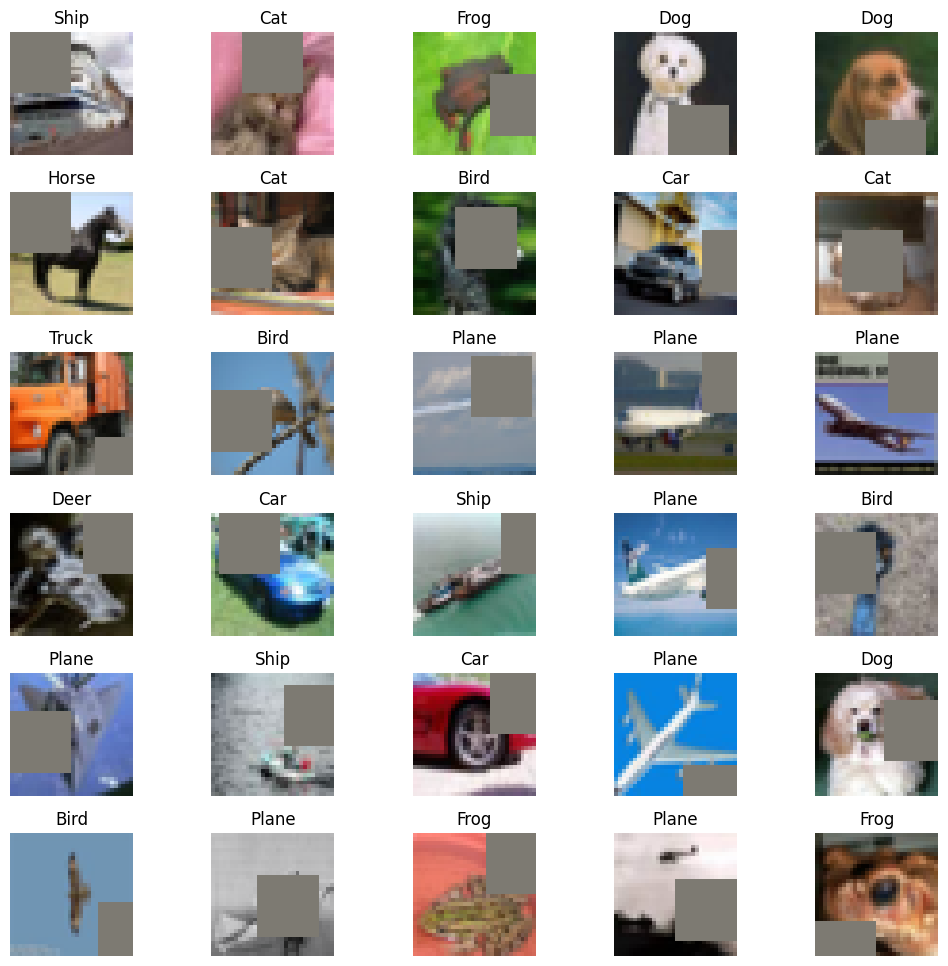

In [14]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(batch_data, batch_label, class_label=classes, num_images=30)
plt.show()

# Model Summary

In [15]:
# Model class is imported from model.py
from model.resnet import ResNet18 as Net

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
#model_summary(model, input_size=(3, 32, 32), device=device)
import torchinfo
# https://github.com/TylerYep/torchinfo
torchinfo.summary(
        model,
        input_size=(3, 32, 32),
        batch_dim=0,
        col_names=(
            "input_size",
            "kernel_size",
            "output_size",
            "num_params",
            "trainable",
        ),
        device=device,
        verbose=1,
        col_width=16,
    )

# disable printing shape for cleaner test train output
model.print_shape = False

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
ResNet                                   [1, 3, 32, 32]   --               [1, 10]          --               True
├─Conv2d: 1-1                            [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
├─Sequential: 1-3                        [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]  [3, 3]           [1, 64, 32, 32]  36,864           True
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
│    │    └─Conv2d: 3-3                  [1, 64, 32, 32]  [3, 3]           [1, 64, 

# Optimizer and Loss Function

In [27]:
# Create optimizer and scheduler
# Use SGD
optimizer = optim.SGD(model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY)

# Define criteria function
criterion = torch.nn.CrossEntropyLoss()

# Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.26E-01


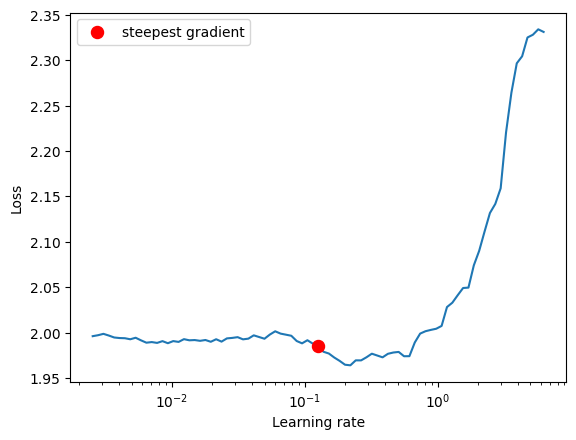

In [28]:
# Find optimal LR to start with
suggested_lr = find_optimal_lr(model, optimizer, criterion, train_loader)

# Scheduler

In [29]:

print(f"Suggested Max LR: {suggested_lr}")

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=100,
    three_phase=False,
    anneal_strategy="linear",
    final_div_factor=100,
    verbose=False,
)

Suggested Max LR: 0.1261856883066021


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


# Train and test model

In [30]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 128, Total epochs: 20


Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train: Loss=1.7195, Batch=390, Accuracy=31.73: 100%|██████████| 391/391 [00:43<00:00,  8.98it/s]


Test set: Average loss: 0.0127,  Accuracy: 39.05%


Epoch 2


Train: Loss=1.4585, Batch=390, Accuracy=42.78: 100%|██████████| 391/391 [00:42<00:00,  9.31it/s]


Test set: Average loss: 0.0108,  Accuracy: 49.93%


Epoch 3


Train: Loss=1.1966, Batch=390, Accuracy=49.58: 100%|██████████| 391/391 [00:42<00:00,  9.17it/s]


Test set: Average loss: 0.0097,  Accuracy: 55.14%


Epoch 4


Train: Loss=1.1658, Batch=390, Accuracy=54.99: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]


Test set: Average loss: 0.0089,  Accuracy: 60.56%


Epoch 5


Train: Loss=0.9871, Batch=390, Accuracy=59.56: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]


Test set: Average loss: 0.0079,  Accuracy: 64.41%


Epoch 6


Train: Loss=0.8292, Batch=390, Accuracy=63.53: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]


Test set: Average loss: 0.0076,  Accuracy: 65.85%


Epoch 7


Train: Loss=1.1107, Batch=390, Accuracy=66.87: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]


Test set: Average loss: 0.0072,  Accuracy: 67.90%


Epoch 8


Train: Loss=0.6638, Batch=390, Accuracy=69.83: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]


Test set: Average loss: 0.0064,  Accuracy: 71.74%


Epoch 9


Train: Loss=0.7682, Batch=390, Accuracy=72.31: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]


Test set: Average loss: 0.0062,  Accuracy: 72.74%


Epoch 10


Train: Loss=0.6007, Batch=390, Accuracy=74.60: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]


Test set: Average loss: 0.0066,  Accuracy: 73.05%


Epoch 11


Train: Loss=0.6838, Batch=390, Accuracy=76.36: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]


Test set: Average loss: 0.0058,  Accuracy: 75.54%


Epoch 12


Train: Loss=0.6809, Batch=390, Accuracy=78.57: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]


Test set: Average loss: 0.0057,  Accuracy: 76.64%


Epoch 13


Train: Loss=0.6251, Batch=390, Accuracy=80.05: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]


Test set: Average loss: 0.0057,  Accuracy: 76.81%


Epoch 14


Train: Loss=0.2824, Batch=390, Accuracy=81.68: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]


Test set: Average loss: 0.0055,  Accuracy: 78.05%


Epoch 15


Train: Loss=0.4243, Batch=390, Accuracy=83.26: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]


Test set: Average loss: 0.0051,  Accuracy: 79.65%


Epoch 16


Train: Loss=0.3936, Batch=390, Accuracy=84.75: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]


Test set: Average loss: 0.0054,  Accuracy: 79.08%


Epoch 17


Train: Loss=0.2487, Batch=390, Accuracy=85.88: 100%|██████████| 391/391 [00:42<00:00,  9.17it/s]


Test set: Average loss: 0.0051,  Accuracy: 79.58%


Epoch 18


Train: Loss=0.4539, Batch=390, Accuracy=87.18: 100%|██████████| 391/391 [00:42<00:00,  9.16it/s]


Test set: Average loss: 0.0059,  Accuracy: 78.25%


Epoch 19


Train: Loss=0.2501, Batch=390, Accuracy=88.20: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]


Test set: Average loss: 0.0058,  Accuracy: 78.54%


Epoch 20


Train: Loss=0.3627, Batch=390, Accuracy=88.99: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]


Test set: Average loss: 0.0058,  Accuracy: 79.09%




# Plots

Plotting accuracy and loss graphs.


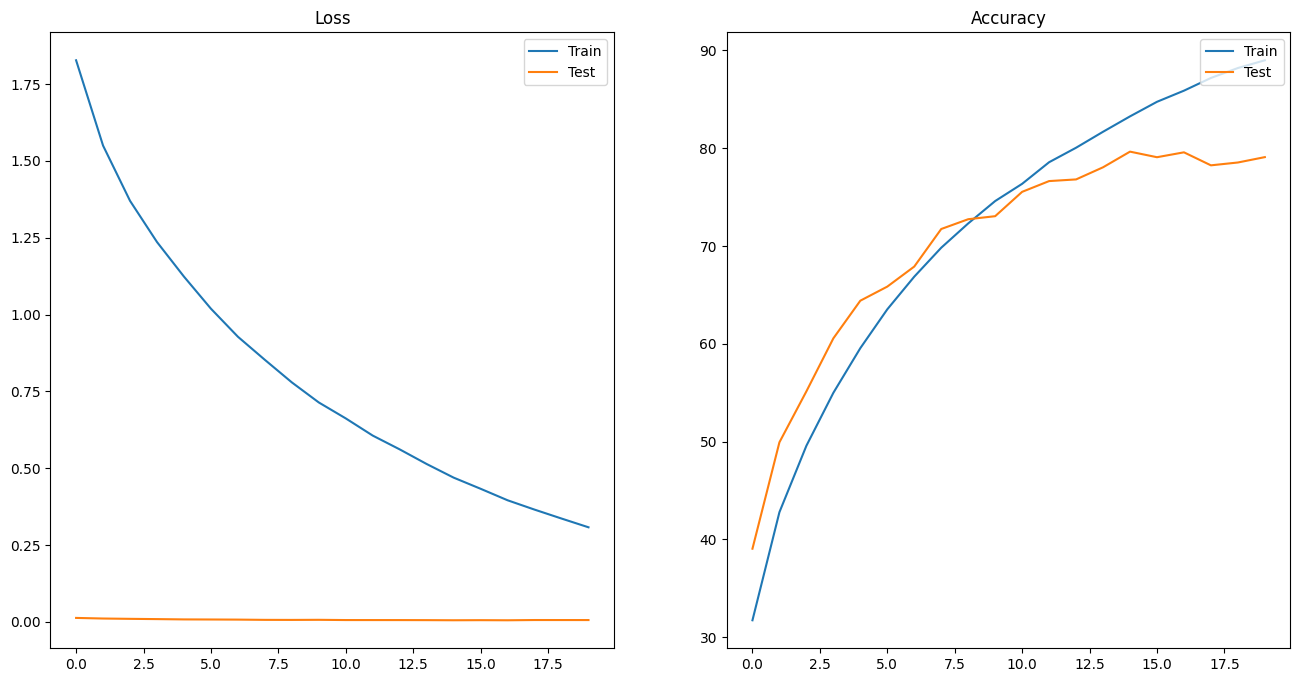

In [31]:
# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()

# Save Model

In [32]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


# Misclassified images

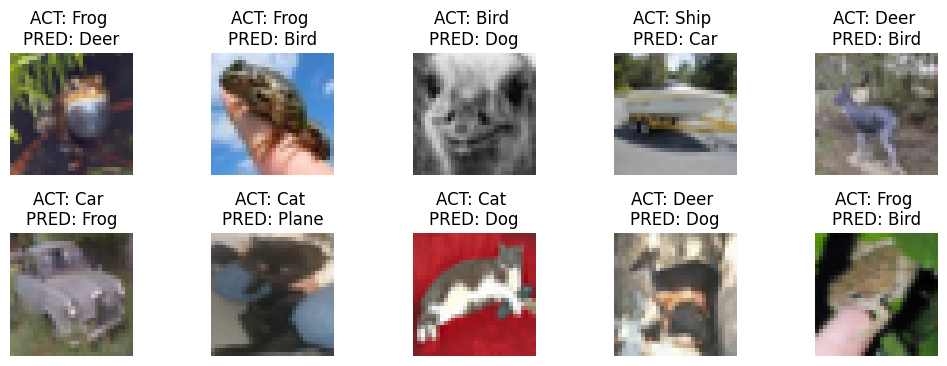

In [33]:
# Plot misclassified images
fig, axs = plot_misclassified_images(data=misclassified_image_data, class_label=classes, num_images=10)
plt.show()
# plt.savefig("Misclassified Images.png")

# GradCAM (Misclassified)

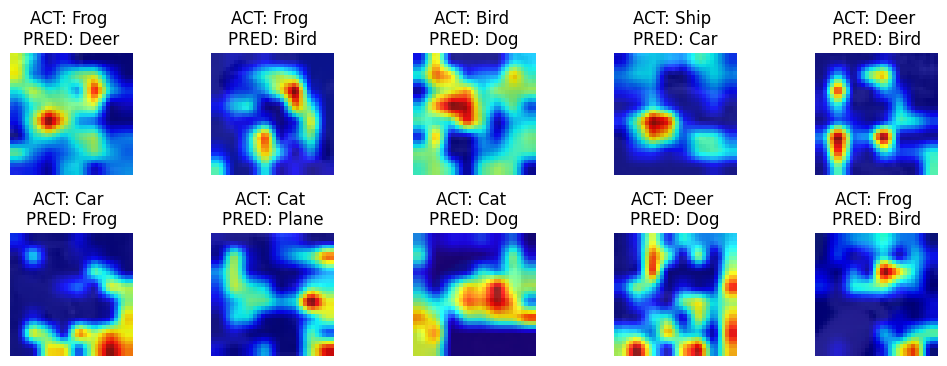

In [34]:
import pytorch_grad_cam
# Plot misclassified images
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    # Decided using model summary so that dimensions > 7x7
    target_layers=[model.layer3[-1]],
    device=device_support,
    targets=None,
    num_images=10,
    image_weight=0.15,
)
plt.show()
# plt.savefig("GradCAM Images.png")